<h1 style='text-align: center;'> MTMW14 Project 2 </h1>
<h2 style='text-align: center;'> Student ID: 31827379 </h2>
    
### 1. Introduction

In [1]:
import assignment2 as assign2

### 2. Task A

\begin{align}
\frac{V_s\Delta t \sqrt{2}}{d} \leq 1
\end{align}

In [2]:
assign2.wavesDemo.displayGravityWave()

,


Figure 1:

In [3]:
assign2.wavesDemo.displayKelvinWave()

,


Figure 2:

CFL criterion.

### 3. Task B

### 4. Task C

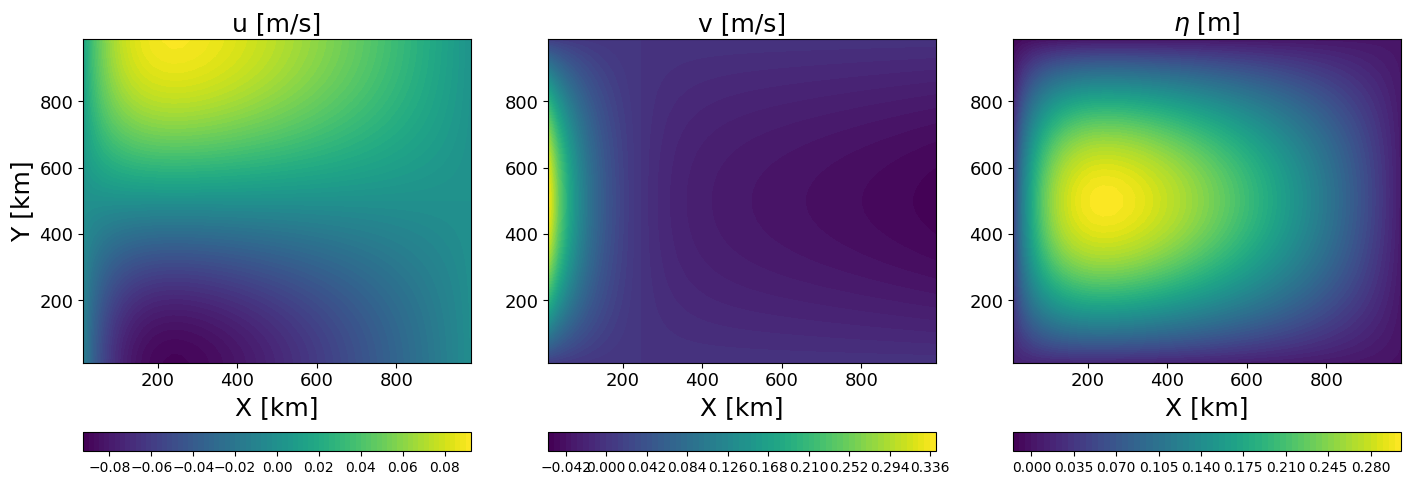

In [4]:
assign2.runTaskC()

Figure 4: 

### 5. Task D

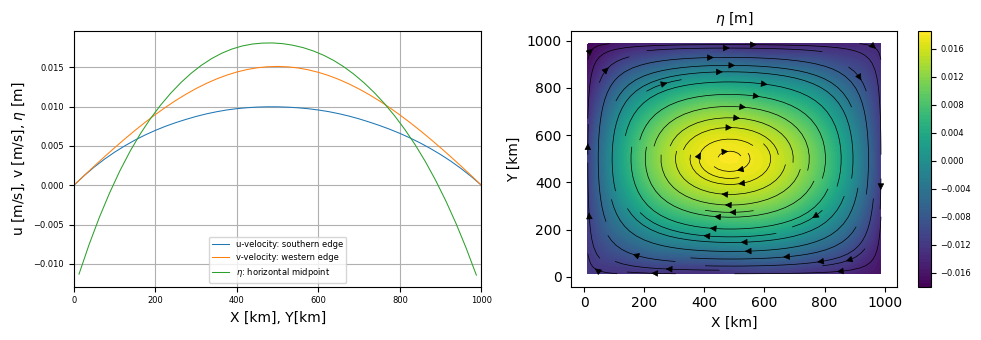

In [5]:
assign2.runTaskD1()

Figure 5:

### 6. Task E

\begin{align}
E(u, v, \eta) = \int\limits_{0}^{L}\int\limits_{0}^{L} \left(\frac{1}{2}\rho\left(H(u^2 + v^2) + g\eta^2\right)\right) \, dx \, dy
\end{align}

### 7. Task F